In [4]:
import pandas as pd
import numpy as np
import re
import math
from random import sample, choice
from sklearn.model_selection import train_test_split
import warnings
import os
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from tqdm import tqdm

In [5]:
def multiple_max(df):
    df1 = df.drop('dataset', axis=1)

    maxes = {}      # {dataset: [max1, max2, ...]}
    for i in range(df.shape[0]):
        row = np.array(df1.iloc[i])
        row_maxes = np.argwhere(row == np.amax(row)).flatten().tolist()
        maxes[df.iloc[i, 0]] = row_maxes
        # maxes[df.iloc[i, 0]] = df1.columns[row_maxes].tolist() # if you want col names
    return maxes

pre = pd.read_csv("emp_results.csv")
pre['dataset'] = pre['dataset'].apply(lambda x: int(re.split(r'\.arff', x)[0]))

optimized_cols = []
default_cols = []

for col in pre.columns:
    if col == 'dataset':
        optimized_cols.append(col)
        default_cols.append(col)
    if "+" in col:
        optimized_cols.append(col)
    elif "-" in col:
        default_cols.append(col)

optim_maxes = multiple_max(pre[optimized_cols])
default_maxes = multiple_max(pre[default_cols])

# optim_maxes = {dataset: [max1, max2, ..., max466]}
# default_maxes = {dataset: [max1, max2, ..., max466]}

## Looking at the distribtuion of optim_maxes

<BarContainer object of 15 artists>

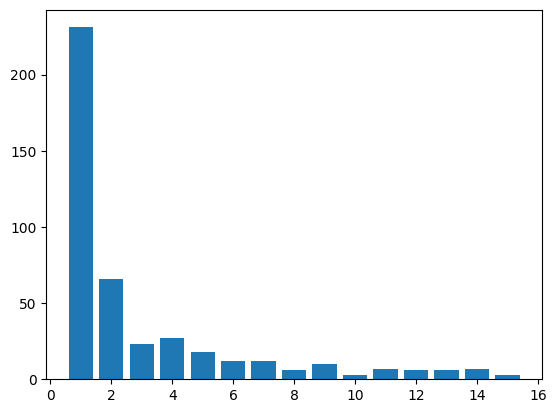

In [13]:
list_algo_counts = [len(optim_maxes[key]) for key in optim_maxes]

# now find the sum of all the numbers in the list 
flattened = np.array(list_algo_counts)
values_og, counts_og = np.unique(list_algo_counts, return_counts=True)

from matplotlib import pyplot as plt
plt.bar(values_og, counts_og)

This graph shows the distribution of the number of maxes in the optim_maxes. 
Future work: want this to be a more even distribution preferably with all of them having approximately the same "best"

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'LogisticRegression()+HO'),
  Text(1, 0, 'Perceptron()+HO'),
  Text(2, 0, 'PassiveAggressiveClassifier()+HO'),
  Text(3, 0, 'RidgeClassifier()+HO'),
  Text(4, 0, 'LinearDiscriminantAnalysis()+HO'),
  Text(5, 0, 'QuadraticDiscriminantAnalysis()+HO'),
  Text(6, 0, 'LinearSVC()+HO'),
  Text(7, 0, 'KNeighborsClassifier()+HO'),
  Text(8, 0, 'NearestCentroid()+HO'),
  Text(9, 0, 'GaussianNB()+HO'),
  Text(10, 0, 'MultinomialNB()+HO'),
  Text(11, 0, 'ComplementNB()+HO'),
  Text(12, 0, 'BernoulliNB()+HO'),
  Text(13, 0, 'DecisionTreeClassifier()+HO'),
  Text(14, 0, 'RandomForestClassifier()+HO'),
  Text(15, 0, 'MLPWrapper()+HO')])

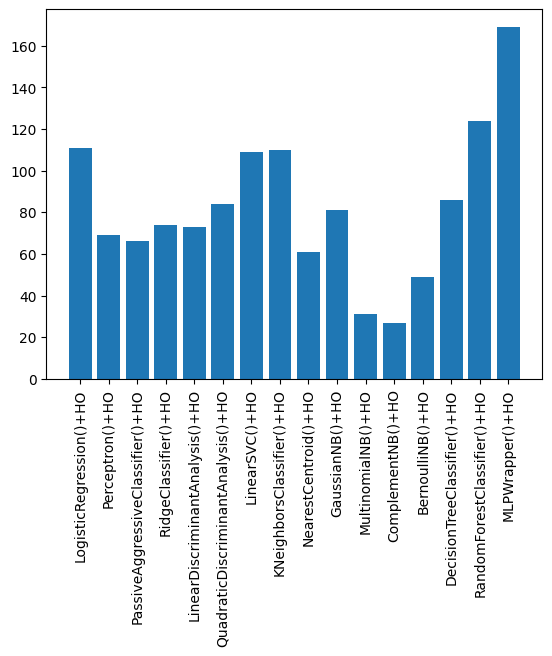

In [14]:
#flatten the entire map of optim_maxes
flattened =[]
for key in optim_maxes:
	flattened = np.append(flattened, optim_maxes[key])

values_og_algo, counts_og_algo = np.unique(flattened, return_counts=True)
# create a dataframe from these two values 
distribution = np.vstack((values_og_algo, counts_og_algo)).T

# box chart of the distribution of the number of times each classifier is the best/in the best list 
# only want optmized_cols from 1-16
plt.bar(optimized_cols[1:], counts_og_algo)
plt.xticks(rotation=90)

From this graph and from the distribution numpy 2d array, we can see that the least common algorithms are the complement, multioniml, and bernoulli NB. and most is the MLP Wrapper. Then Random Forest classifier, KNeighbors classifier, Linear SVC, and Logictic regresssion (The last three look very similar and basically the same )

It is pretty interesting that the NB classifiers preform so poorly. Gaussian and Bernoulli Do preform better, but not by much. 

Next step: create a new optim_maxes but with a better range 

In [45]:
# create new optim_maxes but now including a range of accuracies 
def multiple_max_sd(df):
    df1 = df.drop('dataset', axis=1)
	
    maxes = {}      # {dataset: [max1, max2, ...]}
    #sd = []
    for i in range(df.shape[0]):
        row = np.array(df1.iloc[i])
        row_std = np.std(row)**2
        # sd.append(row_std)
        row_max = np.max(row)
        row_maxes = np.where(np.logical_and(row>=(row_max - row_std), row <= (row_max + row_std)))[0].tolist()
        maxes[df.iloc[i, 0]] = row_maxes
    return maxes
    #return maxes, sd

In [46]:
optim_maxes_sd_2= multiple_max_sd(pre[optimized_cols])

In [37]:
# plt.hist(sd)

In [39]:
# looking to see if the distribtion is better squared? 
# plt.hist([x**2 for x in sd])

<BarContainer object of 15 artists>

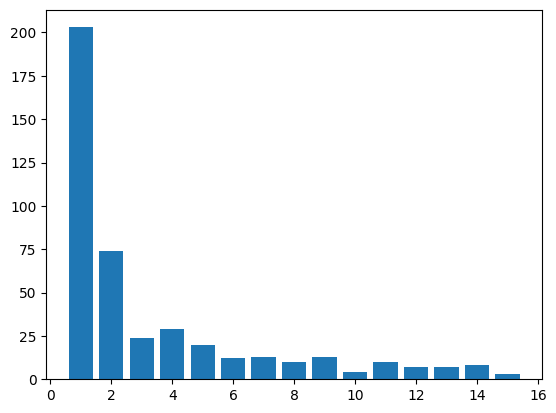

In [40]:
# now do the same analysis as above but with the new optim_maxes_sd
list_algo_counts = [len(optim_maxes_sd[key]) for key in optim_maxes_sd]

# now find the sum of all the numbers in the list 
list_algo_counts = np.array(list_algo_counts)
values_sd, counts_sd = np.unique(list_algo_counts, return_counts=True)

from matplotlib import pyplot as plt
plt.bar(values_sd, counts_sd)

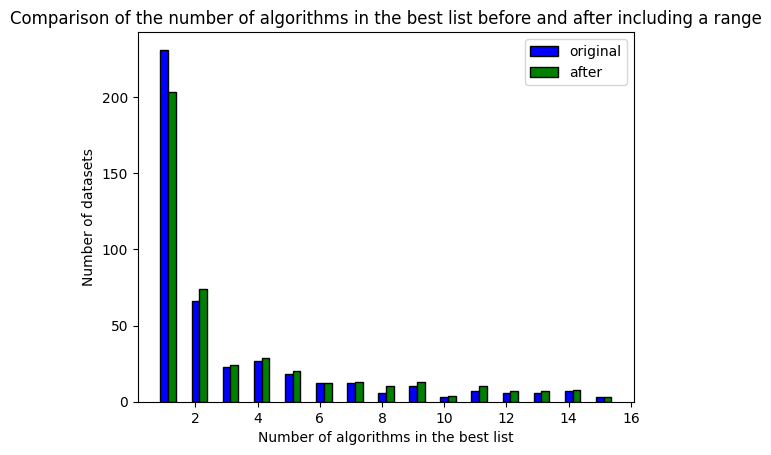

In [41]:
width = 0.25
  
  
plt.bar(values_og, counts_og, color = 'b',
        width = width, edgecolor = 'black',
        label='original')
plt.bar(values_sd + width, counts_sd, color = 'g',
        width = width, edgecolor = 'black',
        label='after')

plt.xlabel("Number of algorithms in the best list")
plt.ylabel("Number of datasets")
plt.title("Comparison of the number of algorithms in the best list before and after including a range")
  
plt.legend()
  
plt.show()

From this you can tell that it is significantly more even distribtuion in optim_maxes.  

In [42]:
#flatten the entire map of optim_maxes_sd
flattened =[]
for key in optim_maxes_sd:
	flattened = np.append(flattened, optim_maxes_sd[key])

values, counts = np.unique(flattened, return_counts=True)
# create a dataframe from these two values 
distribution = np.vstack((values, counts)).T

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, 'LogisticRegression()+HO'),
  Text(1, 0, 'Perceptron()+HO'),
  Text(2, 0, 'PassiveAggressiveClassifier()+HO'),
  Text(3, 0, 'RidgeClassifier()+HO'),
  Text(4, 0, 'LinearDiscriminantAnalysis()+HO'),
  Text(5, 0, 'QuadraticDiscriminantAnalysis()+HO'),
  Text(6, 0, 'LinearSVC()+HO'),
  Text(7, 0, 'KNeighborsClassifier()+HO'),
  Text(8, 0, 'NearestCentroid()+HO'),
  Text(9, 0, 'GaussianNB()+HO'),
  Text(10, 0, 'MultinomialNB()+HO'),
  Text(11, 0, 'ComplementNB()+HO'),
  Text(12, 0, 'BernoulliNB()+HO'),
  Text(13, 0, 'DecisionTreeClassifier()+HO'),
  Text(14, 0, 'RandomForestClassifier()+HO'),
  Text(15, 0, 'MLPWrapper()+HO')])

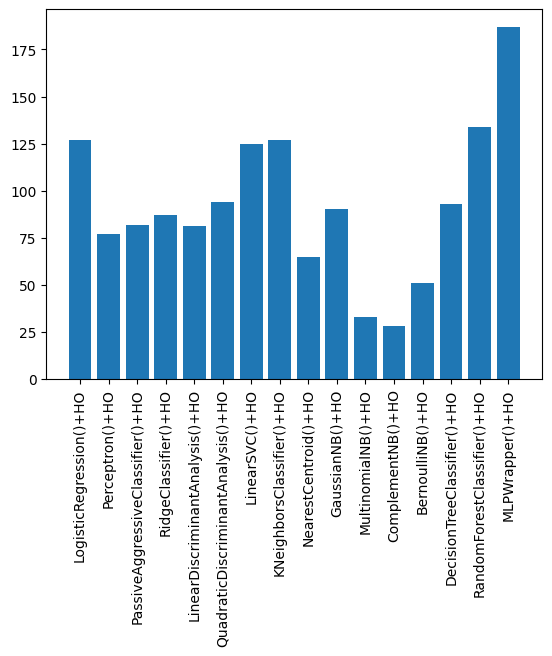

In [43]:
# box chart of the distribution of the number of times each classifier is the best/in the best list 
# only want optmized_cols from 1-16
plt.bar(optimized_cols[1:], counts)
plt.xticks(rotation=90)

now compare the two 

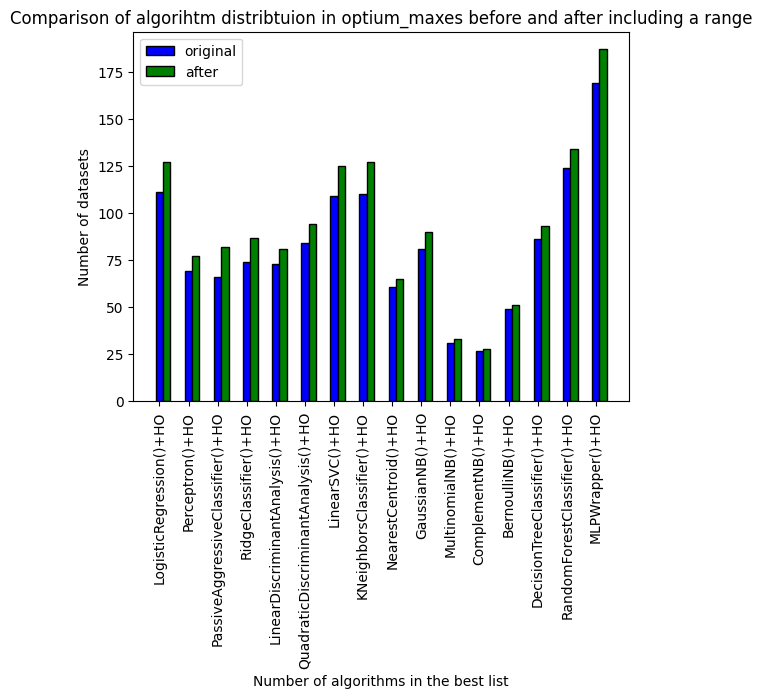

In [44]:
width = 0.25
  
  
plt.bar(optimized_cols[1:], counts_og_algo, color = 'b',
        width = width, edgecolor = 'black',
        label='original')
plt.bar(values + width, counts, color = 'g',
        width = width, edgecolor = 'black',
        label='after')

plt.xlabel("Number of algorithms in the best list")
plt.ylabel("Number of datasets")
plt.title("Comparison of algorihtm distribtuion in optium_maxes before and after including a range")
  
plt.legend()
plt.xticks(rotation=90)
  
plt.show()

## End

In [48]:
def train_meta_model(sk_algorithm, iters, X, y, valid_datasets, maxes):
    accuracies = []
    for i in range(iters):
        X_train, X_test, y_train, y_test, ds_train, ds_test = train_test_split(X, y, valid_datasets,
                                                        test_size=0.33, stratify=y)
        model = sk_algorithm
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        correct = 0
        for ds, prediction in zip(ds_test, y_pred):
            if prediction in maxes[ds]:
                correct += 1
        accuracies.append(correct/len(ds_test))
    return accuracies

In [12]:
# redo train_meta_model but with 2 fold cross validation
def train_meta_model(sk_algorithm, X, y, valid_datasets, maxes):
	accuracies = []
	# for i in range(iters):
	kf = KFold(n_splits=5)
	kf.get_n_splits(X)
	correct = 0
	for train_index, test_index in kf.split(X):
		X_train, X_test = X[train_index], X[test_index]
		y_train, y_test = y[train_index], y[test_index]
		ds_train, ds_test = valid_datasets[train_index], valid_datasets[test_index]
		model = sk_algorithm
		model.fit(X_train, y_train)
		y_pred = model.predict(X_test)
		for ds, prediction in zip(ds_test, y_pred):
			if prediction in maxes[ds]:
				correct += 1
		accuracies.append(correct/len(ds_test))
	return accuracies

In [13]:
# Variables for meta-model
models = ["Metadataset", "RandomForest", "LogisticRegression", "SVC", "KNeighbors",
          "GaussianNB", "DecisionTree", "AdaBoost", "GradientBoosting",
          "MLP", "Bagging", "ExtraTrees",  "Voting"]
results = []
maxes = optim_maxes #optim_maxes_sd # optim_maxes
iters = 5

meta_datasets_path = "meta_datasets"
meta_datasets = {}
for meta_dataset in os.listdir(meta_datasets_path):
    meta_datasets[meta_dataset] = pd.read_csv(os.path.join(meta_datasets_path, meta_dataset))

for df_name, df in tqdm(meta_datasets.items(), desc="Meta-datasets"):
    # df_name, df = choice(list(meta_datasets.items()))
    print('df_name:', df_name)
    results_arr = [df_name]
    X = []
    y = []
    valid_datasets = []

    # df_name, df = choice(list(meta_datasets.items()))
    df.replace(np.nan, 0, inplace=True)
    df.replace(np.inf, 0, inplace=True)
    # print('metadataset:', df_name)

    for i in range(df.shape[0]):
        if df.loc[i, 'dataset'] in maxes:
            y.append(sample(maxes[df.loc[i, 'dataset']],k=1)[0])
            X.append(df.iloc[i, 1:].tolist())
            valid_datasets.append(df.loc[i, 'dataset'])

    X, y = np.array(X), np.array(y)

    # Random Forest
    rf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    rf_accuracies = train_meta_model(rf, X, y, valid_datasets, maxes)
    results_arr.append(np.mean(rf_accuracies))
    # print(f'rf accuracy: {round(np.mean(rf_accuracies)*100,2)}%', flush=True)

    # Logistic Regression
    lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
    lr_accuracies = train_meta_model(lr, X, y, valid_datasets, maxes)
    results_arr.append(np.mean(lr_accuracies))
    # print(f'lr accuracy: {round(np.mean(lr_accuracies)*100,2)}%', flush=True)

    # SVM
    svm = SVC(gamma='auto')
    svm_accuracies = train_meta_model(svm, X, y, valid_datasets, maxes)
    results_arr.append(np.mean(svm_accuracies))
    # print(f'svm accuracy: {round(np.mean(svm_accuracies)*100,2)}%', flush=True)

    # KNN
    knn = KNeighborsClassifier(n_neighbors=3)
    knn_accuracies = train_meta_model(knn, X, y, valid_datasets, maxes)
    results_arr.append(np.mean(knn_accuracies))
    # print(f'knn accuracy: {round(np.mean(knn_accuracies)*100,2)}%', flush=True)

    # Naive Bayes
    nb = GaussianNB()
    nb_accuracies = train_meta_model(nb, X, y, valid_datasets, maxes)
    results_arr.append(np.mean(nb_accuracies))
    # print(f'nb accuracy: {round(np.mean(nb_accuracies)*100,2)}%')

    # Decision Tree
    dt = DecisionTreeClassifier(random_state=0)
    dt_accuracies = train_meta_model(dt, X, y, valid_datasets, maxes)
    results_arr.append(np.mean(dt_accuracies))
    # print(f'dt accuracy: {round(np.mean(dt_accuracies)*100,2)}%')

    # AdaBoost
    ab = AdaBoostClassifier(n_estimators=100, random_state=0)
    ab_accuracies = train_meta_model(ab, X, y, valid_datasets, maxes)
    results_arr.append(np.mean(ab_accuracies))
    # print(f'ab accuracy: {round(np.mean(ab_accuracies)*100,2)}%')

    # Gradient Boosting
    gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    gb_accuracies = train_meta_model(gb, X, y, valid_datasets, maxes)
    results_arr.append(np.mean(gb_accuracies))
    # print(f'gb accuracy: {round(np.mean(gb_accuracies)*100,2)}%')

    # Neural Network
    nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    nn_accuracies = train_meta_model(nn, X, y, valid_datasets, maxes)
    results_arr.append(np.mean(nn_accuracies))
    # print(f'nn accuracy: {round(np.mean(nn_accuracies)*100,2)}%')

    # Bagging
    bg = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=0)
    bg_accuracies = train_meta_model(bg, X, y, valid_datasets, maxes)
    results_arr.append(np.mean(bg_accuracies))
    # print(f'bg accuracy: {round(np.mean(bg_accuracies)*100,2)}%')

    # Extra Trees
    et = ExtraTreesClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
    et_accuracies = train_meta_model(et, X, y, valid_datasets, maxes)
    results_arr.append(np.mean(et_accuracies))
    # print(f'et accuracy: {round(np.mean(et_accuracies)*100,2)}%')

    # Voting Classifier
    vc = VotingClassifier(estimators=[('rf', rf), ('lr', lr), ('svm', svm), ('knn', knn), ('nb', nb), ('dt', dt), ('ab', ab), ('gb', gb), ('nn', nn), ('bg', bg), ('et', et)], voting='hard')
    vc_accuracies = train_meta_model(vc, X, y, valid_datasets, maxes)
    results_arr.append(np.mean(vc_accuracies))
    # print(f'vc accuracy: {round(np.mean(vc_accuracies)*100,2)}%')

    results.append(results_arr)

Meta-datasets:   0%|          | 0/13 [00:00<?, ?it/s]

df_name: info-theory_metadataset.csv


TypeError: only integer scalar arrays can be converted to a scalar index

In [52]:
models = ["Metadataset", "RandomForest", "LogisticRegression", "SVC", "KNeighbors",
          "GaussianNB", "DecisionTree", "AdaBoost", "GradientBoosting",
          "MLP", "Bagging", "ExtraTrees",  "Voting"]

df = pd.DataFrame(results, columns=models)
df

,Metadataset,RandomForest,LogisticRegression,SVC,KNeighbors,GaussianNB,DecisionTree,AdaBoost,GradientBoosting,MLP,Bagging,ExtraTrees,Voting
0,info-theory_metadataset.csv,0.453793,0.428966,0.441379,0.317241,0.281379,0.336552,0.383448,0.369655,0.434483,0.398621,0.434483,0.406897
1,relative_metadataset.csv,0.420833,0.405556,0.458333,0.333333,0.375000,0.313889,0.402778,0.336111,0.402778,0.369444,0.415278,0.451389
2,general_metadataset.csv,0.433103,0.409655,0.453793,0.354483,0.288276,0.388966,0.355862,0.401379,0.419310,0.384828,0.427586,0.455172
3,complexity_metadataset.csv,0.440602,0.275188,0.381955,0.392481,0.203008,0.363910,0.403008,0.350376,0.424060,0.374436,0.479699,0.452632
4,default_metadataset.csv,0.454167,0.322222,0.422222,0.315278,0.247222,0.380556,0.447222,0.362500,0.166667,0.423611,0.441667,0.468056
5,d2v_pretrained_metadaset.csv,0.401379,0.364138,0.419310,0.336552,0.171034,0.337931,0.383448,0.369655,0.204138,0.328276,0.336552,0.380690
6,concept_metadataset.csv,0.447458,0.332203,0.450847,0.311864,0.284746,0.376271,0.298305,0.267797,0.430508,0.342373,0.366102,0.413559
7,model-based_metadataset.csv,0.444615,0.290769,0.476923,0.315385,0.270769,0.384615,0.341538,0.372308,0.187692,0.407692,0.458462,0.443077
8,clustering_metadataset.csv,0.469014,0.363380,0.459155,0.333803,0.269014,0.366197,0.354930,0.376056,0.412676,0.405634,0.439437,0.442254
9,landmarking_metadataset.csv,0.416667,0.441667,0.427778,0.409722,0.347222,0.369444,0.402778,0.276389,0.443056,0.412500,0.440278,0.431944


In [53]:
# df.to_csv('results.csv')
# df.to_csv('results_sd.csv', index=False)
# df.to_csv('results.csv', index=False)
df.to_csv('results_sd_2.csv', index=False)